In [1]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

# import scipy.stats
from scipy.stats import mannwhitneyu
import math
from matplotlib.lines import Line2D

import plot
import calculate

%matplotlib inline

In [2]:
#this defines the criterion which we use to filter authors
CAREER_LENGTH = 1
# this defines how long we follow each cohort
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2018    

### Read authors with start and end year details

In [3]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')

In [4]:
print("authorStartEndCareerData: ", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData.head())

#print(authorStartEndCareerData[authorStartEndCareerData['author'] == 'donatella sciuto'])
authorStartEndCareerData.rename(columns={'num_pub':'total_num_pub'}, inplace=True)

authorStartEndCareerData:  1699352


In [5]:
authorStartEndCareerData.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence,avg_absence,dropped_after_10,gender,early_career_qual,early_career_recognition,succ_after_15y,early_career_prod
0,'maseka lesaoana,2001,2015,2,15,14,7.5,True,none,23.0,5.0,23.0,1
1,(max) zong-ming cheng,2009,2011,2,3,13,7.5,True,none,4.0,4.0,4.0,2
2,(zhou) bryan bai,2011,2012,2,2,14,7.5,True,none,0.0,0.0,0.0,2
3,a aart blokhuis,1992,2005,2,14,13,7.5,True,none,0.0,0.0,0.0,1
4,a ahrabian,2017,2017,1,1,15,15.0,True,none,0.0,0.0,0.0,1


### Read Publication data

In [6]:
authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+str(CAREER_LENGTH)+'-year.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count().reset_index()
author_year_numPub = author_year_numPub.rename(columns={'pub_id':'num_pub'})

print("authorPublicationData: ", authorPublicationData.shape[0])

authorPublicationData.head()

authorPublicationData:  9413377


,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [7]:
author_year_numPub.head()

,author,year,num_pub
0,'maseka lesaoana,2001,1
1,'maseka lesaoana,2015,1
2,(max) zong-ming cheng,2009,1
3,(max) zong-ming cheng,2011,1
4,(zhou) bryan bai,2011,1


In [8]:
authorPublicationData[authorPublicationData["author"] == "'maseka lesaoana"]

,author,year,pub_id
4543408,'maseka lesaoana,2015,2a10f544-51ac-4261-8a26-cf61c1abdc03
4896492,'maseka lesaoana,2001,4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa


## Publications analysis

In [90]:
author_year_numPub_with_authors = author_year_numPub.merge(authorStartEndCareerData[['author','start_year', 'gender']], on="author")

groupByYearData = calculate.calculate_cumulative_for_authors(author_year_numPub_with_authors, 'num_pub')

years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

In [91]:
step = 5
cohort_start_years = list(range(years[0], END_YEAR - MAX_CAREER_LENGTH_COHORT + step, step))
skip_overlaping_years = False

In [92]:
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
print(groupByYearData[groupByYearData['author'] == '(max) zong-ming cheng'].head(10))

         year            author  num_pub  start_year gender  cum_num_pub
733467   2001  'maseka lesaoana        1        2001   none            1
4142431  2015  'maseka lesaoana        1        2001   none            2
         year                 author  num_pub  start_year gender  cum_num_pub
2211746  2009  (max) zong-ming cheng        1        2009   none            1
2794612  2011  (max) zong-ming cheng        1        2009   none            2


#### Tests

In [93]:
from importlib import reload
reload(plot)
reload(calculate)

<module 'calculate' from '/home/danielkostic/cumulative-advantage/calculate.py'>

In [47]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", authorStartEndCareerData)

#------------------------------------------
# some plausibility checks
print(cohort_careerage_df.head(n=1))
subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & 
                              (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & 
                               (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))


KeyboardInterrupt: 

In [ ]:
groupByYearData[groupByYearData['year'] == 2018].shape

In [ ]:
groupByYearData[groupByYearData['year'] == 2018]['num_pub'].sum()

## Run cohort analysis

In [94]:
from plot import *
groupByYearData, cohort_start_years, max_career_age_cohort, criterion, criterion_display, authorStartEndCareerData, \
skip_overlaping_years = groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", \
authorStartEndCareerData, skip_overlaping_years

In [95]:
cohort_start_years

[1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005]

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


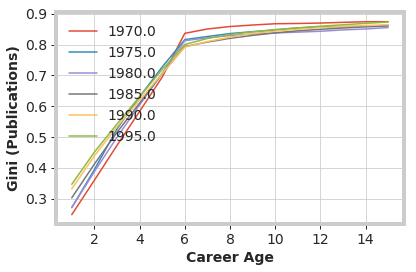

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


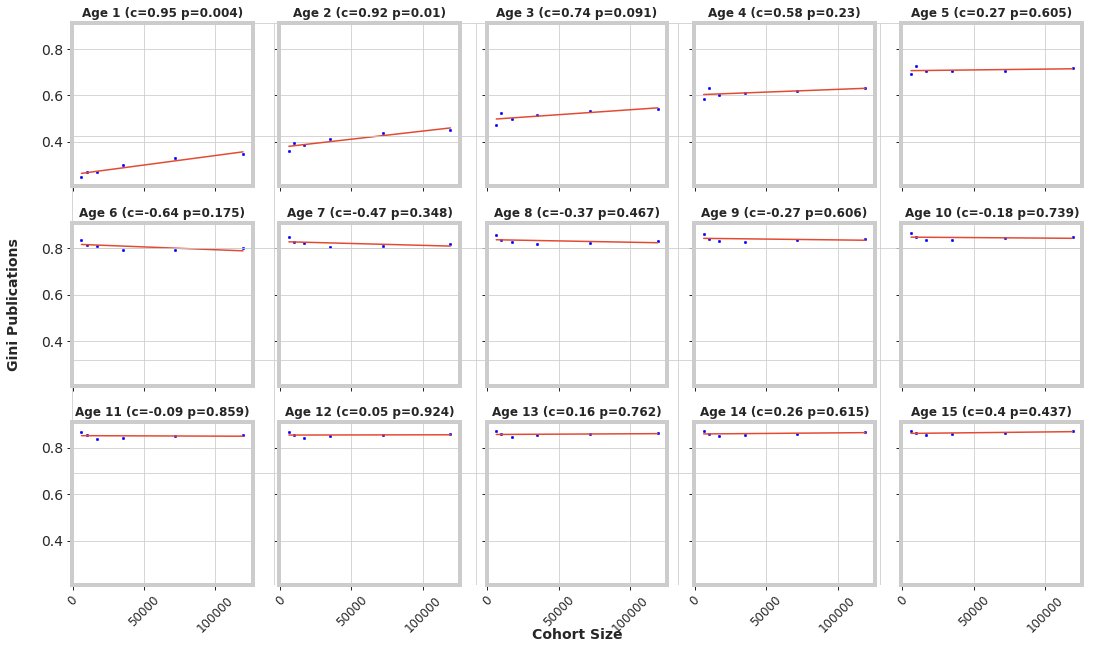

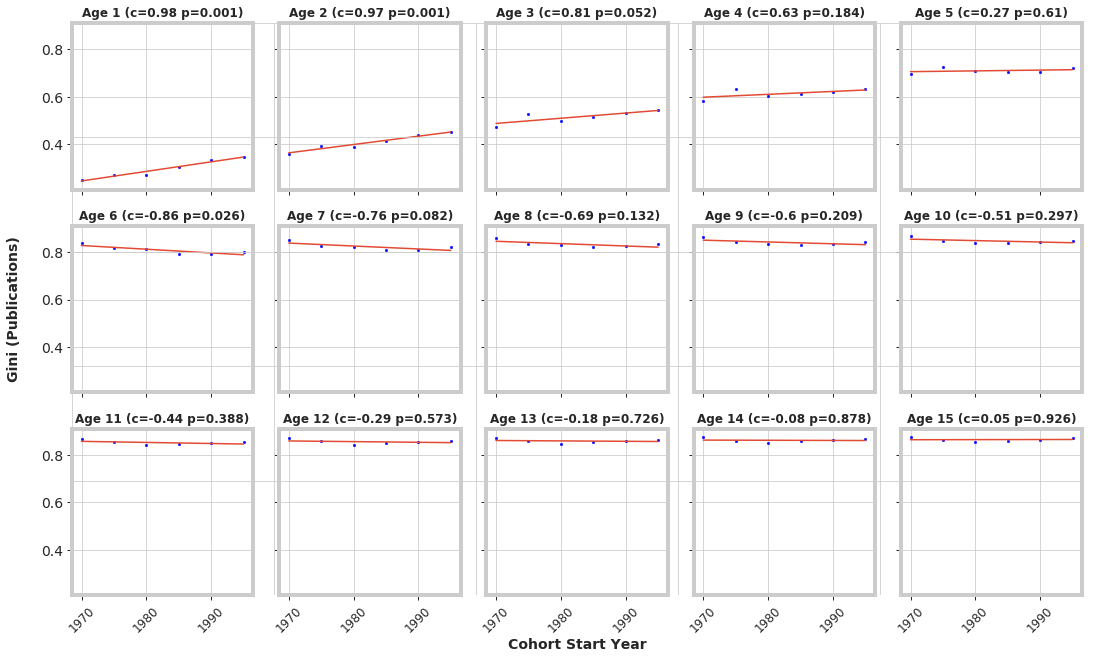

In [96]:
print("get_cohort_careerage_df")
cohort_careerage_df = get_cohort_careerage_df(groupByYearData, cohort_start_years, max_career_age_cohort, criterion, authorStartEndCareerData)

#gini
cohort_size_gini = get_cohort_size_gini(cohort_careerage_df,criterion, cohort_careerage_df["cohort_start_year"].unique())
#cohort_size_gini = get_cohort_gini(cohort_careerage_df,criterion, np.array([1970, 1980, 1990, 2000]))

print("plot_gini")
plot_gini(cohort_size_gini, criterion, criterion_display)
print("plot_cohort_size_gini_cor")
plot_cohort_size_gini_cor(cohort_size_gini,  criterion, criterion_display)


,cohort_start_year,cohort_size,age,criterion,mean,std,sem,median,mean_f,median_f,std_f,sem_f,mean_m,median_m,std_m,sem_m,mean_n,median_n,std_n,sem_n
0,1970,6181,1,num_pub,0.281346,0.21582,0.002745,0.2,0.256858,0.2,0.228099,0.011391,0.282045,0.2,0.204105,0.003479,0.284517,0.2,0.22972,0.004751


plot_cohort_means_over_ages


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


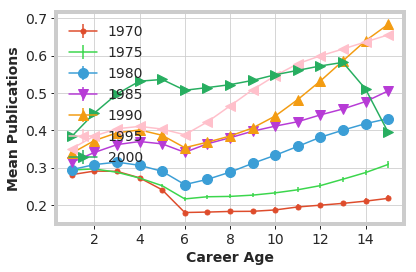

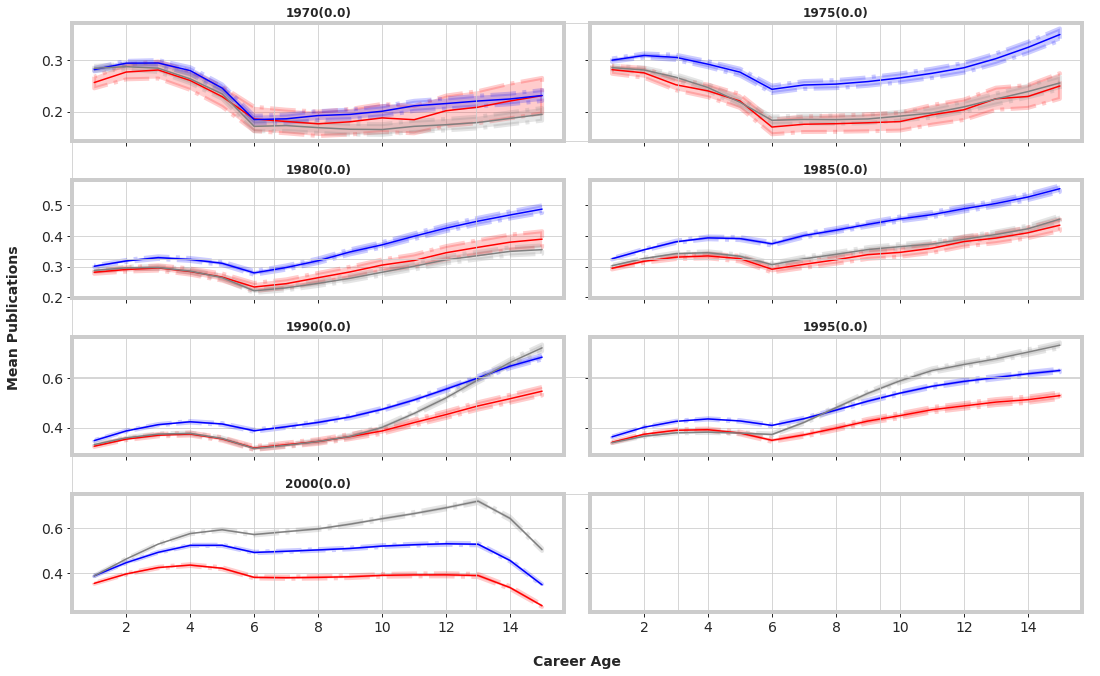

In [97]:
# mean/std/median
stats = get_cohort_stats(cohort_careerage_df, criterion)
display(stats.head(n=1))
# doesnt plot anything
#     plot_cohort_gender_diffs(stats, criterion, criterion_display)
print("plot_cohort_means_over_ages")
plot_cohort_means_over_ages(stats, criterion, criterion_display)

In [ ]:
# plot overall gini for all authors that started between 1970 and 2000, ignore cohorts
cohort_size_gini = get_cohort_size_gini(cohort_careerage_df,criterion, np.array([1970, 2000]))
print("plot_gini [1970, 2000]")
plot_gini(cohort_size_gini, criterion+"_ALL_AUTHORS", criterion_display)

cohort_size_gini = get_cohort_size_gini(cohort_careerage_df,criterion, np.array([1970, 1980, 1990, 2000]))
print("plot_gini [1970, 1980, 1990, 2000]")
plot_gini(cohort_size_gini, criterion+"_COHORTS_10_YEARS", criterion_display)

In [83]:
stats[stats.cohort_start_year == 1988]

,cohort_start_year,cohort_size,age,criterion,mean,std,sem,median,mean_f,median_f,std_f,sem_f,mean_m,median_m,std_m,sem_m,mean_n,median_n,std_n,sem_n
90,1988,28528,1,num_pub,0.454337,0.300279,0.001778,0.333333,0.441634,0.333333,0.266172,0.004793,0.460660,0.333333,0.311102,0.002538,0.448978,0.333333,0.293611,0.002877
91,1988,28528,2,num_pub,0.441146,0.435513,0.002578,0.333333,0.417856,0.333333,0.400664,0.007215,0.457000,0.333333,0.451067,0.003680,0.425170,0.333333,0.421461,0.004129
92,1988,28528,3,num_pub,0.397364,0.551456,0.003265,0.333333,0.359706,0.333333,0.491413,0.008849,0.421286,0.333333,0.572630,0.004671,0.374004,0.333333,0.535274,0.005245
93,1988,28528,4,num_pub,0.311635,0.635114,0.003760,0.000000,0.267294,0.000000,0.553062,0.009959,0.339677,0.000000,0.667069,0.005442,0.284311,0.000000,0.608067,0.005958
94,1988,28528,5,num_pub,0.336406,0.723670,0.004285,0.000000,0.284371,0.000000,0.626562,0.011283,0.368404,0.000000,0.761188,0.006209,0.305654,0.000000,0.692048,0.006781
95,1988,28528,6,num_pub,0.355440,0.810864,0.004801,0.000000,0.303826,0.000000,0.736575,0.013264,0.389987,0.000000,0.852436,0.006954,0.320886,0.000000,0.766865,0.007514
96,1988,28528,7,num_pub,0.369181,0.885707,0.005244,0.000000,0.313013,0.000000,0.804641,0.014489,0.407688,0.000000,0.932313,0.007605,0.330261,0.000000,0.835601,0.008187
97,1988,28528,8,num_pub,0.379253,0.945364,0.005597,0.000000,0.333874,0.000000,0.854086,0.015380,0.415607,0.000000,0.995073,0.008117,0.340245,0.000000,0.893957,0.008759
98,1988,28528,9,num_pub,0.393964,1.013343,0.006000,0.000000,0.345547,0.000000,0.902928,0.016259,0.435084,0.000000,1.071254,0.008739,0.348981,0.000000,0.954044,0.009348
99,1988,28528,10,num_pub,0.411350,1.088808,0.006446,0.000000,0.357760,0.000000,0.946231,0.017039,0.455691,0.000000,1.154365,0.009417,0.363252,0.000000,1.026289,0.010055


In [89]:
author_year_numPub_with_authors[(author_year_numPub_with_authors.start_year == 1988) & 
                                (author_year_numPub_with_authors.year == 1988) &
                                (author_year_numPub_with_authors.gender == 'm')]['num_pub'].mean()

1.1433494141971055

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", 
                         authorStartEndCareerData, skip_overlaping_years)  

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications", 
                         authorStartEndCareerData, skip_overlaping_years)  